Here I use LSTM model for multivariate time-series prediction, the model output is day by day.

## Libraries

In [33]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from numpy import concatenate

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [14]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

### Cite Jason ML's function to process time-series data for supervised learning
https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [3]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

## Load data and exploration

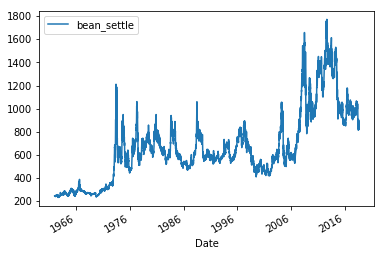

In [4]:
soybean = pd.read_csv('ALL_Prices_soybean.csv', index_col = 'Date', parse_dates=True).sort_index()
# examine NA
soybean.isna().sum(axis=0)
# describe soybean
soybean.describe()
# drop duplicates
soybean.drop_duplicates(inplace=True)

# Market_Open = 1
soybean = soybean.loc[soybean['Market_Open'] == 1]
# soybean price plot
soybean.plot(y='bean_settle')

## Feature engineering

In [9]:
rolling_feature = ['bean_settle']
rolling_wins = [5, 10, 20, 60]
for var in rolling_feature:
    for num in rolling_wins:
        soybean[var+str(num)] = soybean[var].rolling(num).aggregate(np.mean)

keep = ['bean_settle', 'bean_high', 'bean_low', 'bean_settle5', 'bean_settle10', 'bean_settle20', 'bean_settle60',
        'Gold', 'USD', 'Oil']    
soybean = soybean.filter(items=keep)

In [10]:
# normalizing numerical features
soybean.dropna(inplace=True)
StdScaler = StandardScaler()
soybean.loc[:, keep] = StdScaler.fit_transform(soybean.loc[:, keep])
soybean.loc[:, keep] = soybean.loc[:, keep].astype('float32')

## Pre-processing for LSTM

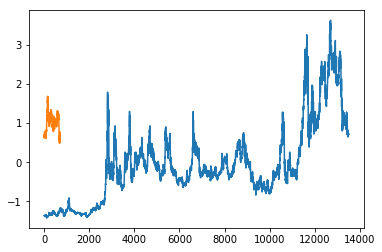

In [41]:
reframed = series_to_supervised(soybean.values, 1, 1)

#%% Split data
reframed.drop(reframed.columns[np.arange(11,20)], axis=1, inplace=True)
reframed = reframed.values

train, test = reframed[:round(len(reframed)*.95), :], reframed[round(len(reframed)*.95):, :] 
x_train, y_train = train[:, :-1], train[:, -1]
x_test, y_test = test[:, :-1], test[:, -1]

plt.plot(x_train[:,0])
plt.plot(x_test[:,0])
plt.show()

In [42]:
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(13500, 1, 10) (13500,) (711, 1, 10) (711,)


## LSTM model

In [43]:
model = Sequential()
#  1st hidden layer
model.add(LSTM(30, input_shape=(x_train.shape[1], x_train.shape[2]), activation='relu', return_sequences=True))
#  2nd hidden layer
model.add(LSTM(15, activation='relu'))
# output layer
model.add(Dense(1))
# metric & optimizer
model.compile(loss='mean_squared_error', optimizer='adam')
# fit model
history = model.fit(x_train, y_train, epochs=100, batch_size=round(len(x_train)*0.2), validation_data=(x_test, y_test), verbose=2, shuffle=False)

Train on 13500 samples, validate on 711 samples
Epoch 1/100
 - 2s - loss: 0.9961 - val_loss: 1.0567
Epoch 2/100
 - 0s - loss: 0.9821 - val_loss: 1.0477
Epoch 3/100
 - 0s - loss: 0.9688 - val_loss: 1.0360
Epoch 4/100
 - 0s - loss: 0.9554 - val_loss: 1.0210
Epoch 5/100
 - 0s - loss: 0.9411 - val_loss: 1.0046
Epoch 6/100
 - 0s - loss: 0.9264 - val_loss: 0.9880
Epoch 7/100
 - 0s - loss: 0.9105 - val_loss: 0.9699
Epoch 8/100
 - 0s - loss: 0.8922 - val_loss: 0.9486
Epoch 9/100
 - 0s - loss: 0.8713 - val_loss: 0.9246
Epoch 10/100
 - 0s - loss: 0.8478 - val_loss: 0.8977
Epoch 11/100
 - 0s - loss: 0.8207 - val_loss: 0.8677
Epoch 12/100
 - 0s - loss: 0.7895 - val_loss: 0.8342
Epoch 13/100
 - 0s - loss: 0.7533 - val_loss: 0.7965
Epoch 14/100
 - 0s - loss: 0.7101 - val_loss: 0.7543
Epoch 15/100
 - 0s - loss: 0.6597 - val_loss: 0.7070
Epoch 16/100
 - 0s - loss: 0.6018 - val_loss: 0.6542
Epoch 17/100
 - 0s - loss: 0.5365 - val_loss: 0.5956
Epoch 18/100
 - 0s - loss: 0.4654 - val_loss: 0.5319
Epoch 1

### plot training error

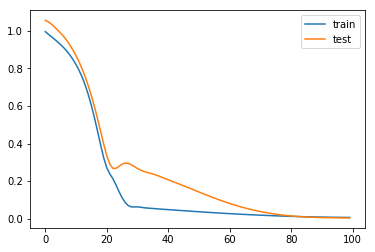

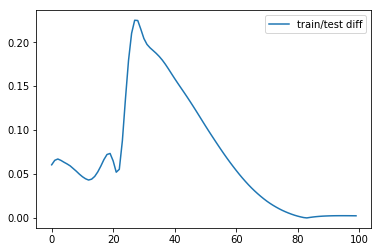

In [44]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

plt.plot(np.abs(np.array(history.history['loss']) - np.array(history.history['val_loss'])), label='train/test diff')
plt.legend()
plt.show()

### Evaluation

In [45]:
# performance evaluation
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [46]:
# prediction
yhat = model.predict(x_test)
x_test = x_test.reshape((x_test.shape[0], x_test.shape[2]))

Test MSE: 350.34 and MAPE: 1.43%


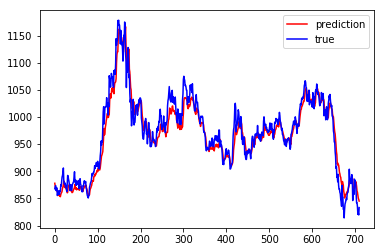

In [47]:
# inverse transform y_hat
inv_yhat = concatenate((yhat, x_test[:, 1:]), axis=1)
inv_yhat = StdScaler.inverse_transform(inv_yhat)
y_pred = inv_yhat[:,0]

# inver transform y
y_test = y_test.reshape((len(y_test), 1))
inv_y = concatenate((y_test, x_test[:, 1:]), axis=1)
inv_y = StdScaler.inverse_transform(inv_y)
y_true = inv_y[:,0]

mse_test = mean_squared_error(y_true, y_pred)
mape_test = mean_absolute_percentage_error(y_true, y_pred)
print("Test MSE: {:.2f} and MAPE: {:.2f}%".format(mse_test, mape_test))

# plot y_pred vs y_true
plt.plot(y_pred, 'r', label='prediction')
plt.plot(y_true, 'b', label='true')
plt.legend()
plt.show()

## Short summary

Adding one more layer in LSTM model would further improve MAPE.